In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
import numpy as np
import pandas as pd
import awkward as ak
from numba import njit
import vector
vector.register_numba()
vector.register_awkward()
import torch
import scipy

from pprint import pprint 
hep.style.use(hep.style.ROOT)

import hist
import plot_loss
from torch import optim
from tqdm.notebook import trange

from sklearn.preprocessing import StandardScaler

# Prepare the dataset

In [3]:
#df = ak.from_parquet("/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_v6.parquet")
df = ak.from_parquet("all_jets_v6.parquet")

In [4]:
(jets,
partons_matched,
partons,
generator_info,
lepton_partons,
lepton_reco, 
met
) = ak.unzip(df)

jets = ak.with_name(jets, name="Momentum4D")
partons_matched = ak.with_name(partons_matched, name="Momentum4D")
partons = ak.with_name(partons, name="Momentum4D")
lepton_partons = ak.with_name(lepton_partons, name="Momentum4D")
lepton_reco = ak.with_name(lepton_reco, name="Momentum4D")
met = ak.with_name(met, name="Momentum4D")

In [5]:
@njit
def sum_vectors_all(arrays):
    size = len(arrays)
    results = np.zeros((size, 4))
    for i, array in enumerate(arrays):
        total = vector.obj(px=0.0, py=0.0, pz=0.0, E=0.0)
        for v in array:
            total = total + v
        results[i, 0] = total.px
        results[i, 1] = total.py
        results[i, 2] = total.pz
        results[i, 3] = total.E
    return results


def get_vector_sum(vectors):
    out = sum_vectors_all(vectors)
    return vector.awk({
        "px": out[:, 0],
        "py": out[:, 1],
        "pz": out[:, 2],
        "E": out[:, 3],
    })

In [6]:
boost_jets = get_vector_sum(jets)
boost_reco = boost_jets + lepton_reco + met

initial_pz = 6500*(generator_info.x1 - generator_info.x2)
initial_E = 6500*(generator_info.x1 + generator_info.x2)

initial_boost = ak.Array(
    {"px": np.zeros_like(initial_pz), "py": np.zeros_like(initial_pz), "pz": initial_pz, "E": initial_E},
    with_name="Momentum4D"
)

## Convert the dataset to torch

In [7]:
#Column 1 is pz, column 2 is E
y_cond = np.stack( [ 
    ak.to_numpy(boost_reco.pz, allow_missing=None),
    ak.to_numpy(boost_reco.E, allow_missing=None)]).T

array([[ 557.26771986,  707.36037147],
       [1952.8069725 , 2215.60626402],
       [-432.7080822 ,  684.2705409 ],
       ...,
       [-647.29124928, 1052.08657337],
       [-503.69562626,  882.34073397],
       [  -7.0186224 , 1141.42667515]])

In [8]:
# Rescaling
#Y_scaled = torch.from_numpy(np.sign(y_cond)*np.log(abs(y_cond))).float()
#Y_scaled[:,1] -= 7

scaler = StandardScaler()

Y_scaled = torch.from_numpy(scaler.fit_transform(y_cond)).float()

x_target = np.stack( [ 
    ak.to_numpy(generator_info.x1, allow_missing=None),
    ak.to_numpy(generator_info.x2, allow_missing=None)]).T

x_target_torch = torch.from_numpy(x_target).float()

# transform it to pz and E
X = torch.zeros_like(x_target_torch)
X[:,0] = 6500*(x_target_torch[:,0]-x_target_torch[:,1])
X[:,1] = 6500*(x_target_torch[:,0]+x_target_torch[:,1])


X_scaled = torch.from_numpy(scaler.transform(X)).float()

In [ ]:
plt.hist(y_cond[:,0], bins=100, histtype="step", label="not scaled - Pz");
plt.hist(y_cond[:,1], bins=100, histtype="step", label="not scale - E");
plt.yscale("log")
plt.title("conditioning")
plt.legend()
plt.show()

plt.hist(Y_scaled[:,0].numpy(), bins=100, histtype="step", label="scaled - Pz");
plt.hist(Y_scaled[:,1].numpy(), bins=100, histtype="step", label="scaled - E");
plt.yscale("log")
plt.title("conditioning (scaled)")
plt.legend()
plt.show()

In [ ]:
plt.hist(X[:,0].numpy(), bins=100, histtype="step", label="not scaled - Pz");
plt.hist(X[:,1].numpy(), bins=100, histtype="step", label="not scale - E");
plt.yscale("log")
plt.title("target")
plt.legend()
plt.show()

plt.hist(X_scaled[:,0].numpy(), bins=100, histtype="step", label="scaled - Pz");
plt.hist(X_scaled[:,1].numpy(), bins=100, histtype="step", label="scaled - E");
plt.yscale("log")
plt.title("target (scaled)")
plt.legend()
plt.show()

In [ ]:
plt.hist2d(X[:,1].numpy(),
           y_cond[:,1],
           bins=[100,100],cmap="inferno", cmin=1, norm=LogNorm());
plt.xlabel("E target")
plt.ylabel("E reco (conditioning)")
plt.show()

plt.hist2d(X_scaled[:,1].numpy(),
           Y_scaled[:,1].numpy(),
           bins=[100,100], cmap="inferno", cmin=1, norm=LogNorm());
plt.xlabel("E target (scaled)")
plt.ylabel("E reco (conditioning) - scaled")
plt.show()

In [ ]:
plt.hist2d(X[:,0].numpy(),
           y_cond[:,0],
           bins=[100,100],cmap="inferno", cmin=1, norm=LogNorm());
plt.xlabel("Pz target")
plt.ylabel("Pz reco (conditioning)")
plt.show()

plt.hist2d(X_scaled[:,0].numpy(),
           Y_scaled[:,0].numpy(),
           bins=[100,100],
           range=[[-10,10],[-10,10]], cmap="inferno", cmin=1, norm=LogNorm());
plt.xlabel("Pz target (scaled)")
plt.ylabel("Pz reco (conditioning) - scaled")
plt.show()

In [ ]:
plt.hist2d(y_cond[:,0],
           y_cond[:,1],
           bins=[100,100], range=[[-4000, 4000], [0,4000]], cmap="inferno", cmin=1, norm=LogNorm());
plt.xlabel("Pz reco (conditioning)")
plt.ylabel("E reco (conditioning)")
plt.show()

# Define the flow

In [9]:
import zuko
from zuko.flows import TransformModule, SimpleAffineTransform
from zuko.distributions import BoxUniform, DiagNormal

In [10]:
def build_flow(features, ntransforms=4, context=None, hidden_mlp=[32]*3, bins=8, autoregressive=True):
    flow = zuko.flows.NSF(features, context=context, transforms=ntransforms, bins=bins, hidden_features=hidden_mlp, 
                      randperm=True,
                      base=BoxUniform,
                      base_args=[torch.ones(features)*(-1),torch.ones(features)],
                      univariate_kwargs={"bound": 1 }, # Keeping the flow in the [-1,1] box.
                      passes = 2 if not autoregressive else features)

    flow.transforms.insert(0, SimpleAffineTransform(0*torch.ones(features),1*torch.ones(features),
                                                 -1*torch.ones(features), 1*torch.ones(features)))
    
    return flow

def build_flow_gauss(features, ntransforms=4, context=None, hidden_mlp=[32]*3, bins=8, autoregressive=True):
    flow = zuko.flows.NSF(features, context=context, transforms=ntransforms, bins=bins, hidden_features=hidden_mlp, 
                      randperm=True,
                      base=DiagNormal,
                      univariate_kwargs={"bound": 10},
                      passes= 2 if not autoregressive else features)
    return flow

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
#flow = zuko.flows.MAF(2, context=2, transforms=6, hidden_features=[32, 32], 
#                      randperm=True,
#                      base=DiagNormal)

#flow = build_flow(features=2, ntransforms=3, context=2, hidden_mlp=[32], bins=8, autoregressive=True)

flow = build_flow_gauss(features=2, ntransforms=4, context=2, hidden_mlp=[32]*2, bins=8, autoregressive=True)

In [ ]:
out = flow(Y_scaled[0:10000]).sample((1, )).squeeze(0)
out.shape

In [ ]:
plt.hist2d(out[:,0].numpy(), 
           Y_scaled[0:10000, 0].numpy(), 
          bins=100,cmap="inferno", cmin=1, norm=LogNorm())
plt.xlabel("Pz generated")
plt.ylabel("Pz reco (conditioning)")
plt.title("no training")
plt.show()

In [ ]:
plt.hist2d(out[:,0].numpy(), out[:,1].numpy(),
           bins=100, cmap="inferno", cmin=1, norm=LogNorm());

# Training loop

In [14]:
nepochs = 50
batch_size = 2048
lr_init = 0.0001
N_training_samples = len(Y_scaled)

In [20]:
flow = build_flow_gauss(features=2, ntransforms=4, context=2, hidden_mlp=[32], bins=10, autoregressive=True)
flow = flow.to("cuda")
optimizer = optim.Adam(flow.parameters(), lr=lr_init)

#decay = 0.01
#fcn = lambda step: 1./(1. + decay*step)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=fcn)

plotter = plot_loss.LossPlotter(["loss"])

print(count_parameters(flow))

8296


In [21]:
X_scaled = X_scaled.to("cuda")
Y_scaled = Y_scaled.to("cuda")

In [22]:
for e in trange(0, nepochs, desc="Epoch"):
    
    permutation = torch.randperm(N_training_samples).to("cuda")
    t = trange(0, N_training_samples, batch_size, desc="Batch")
    for i in t:
            
        indices = permutation[i:i+batch_size]
        
        optimizer.zero_grad()

        logp_g =  flow(Y_scaled[indices]).log_prob(X_scaled[indices])

        loss =  - logp_g.mean()
        loss.backward()

        optimizer.step()     

        #plotter.on_epoch_end({"loss": loss.item()})
        if i % (batch_size *20) == 0:
            t.set_description(f"{loss.item():.4f}", refresh=True)
    
#     with torch.no_grad():
#         out = flow(Y_scaled[0:30000]).sample((1, )).squeeze(0)
#         plt.hist2d(out[:,0].numpy(), 
#                    Y_scaled[0:30000,0].numpy(), 
#                    bins=100,cmap="inferno", cmin=1, norm=LogNorm() );
#         plt.xlabel("Pz generated")
#         plt.ylabel("Pz reco (conditioning)")
        
#         # plt.hist2d(out[:,0].numpy(), out[:,1].numpy(),
#         #    bins=100, cmap="inferno", cmin=1, norm=LogNorm());
        
#         plt.show()
#         plt.close()


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

Batch:   0%|          | 0/286 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [23]:
out = flow(Y_scaled).sample((1, )).squeeze(0)
out.shape


torch.Size([584143, 2])

In [24]:
flow = flow.cpu()
out = out.cpu()
X_scaled = X_scaled.cpu()
Y_scaled = Y_scaled.cpu()

In [ ]:
plt.hist2d(out[:,0].numpy(), 
           Y_scaled[:,0].numpy(), 
          bins=100,range=[[-10,10],[-10,10]],
           cmap="inferno", cmin=1, norm=LogNorm() );
plt.xlabel("Pz generated")
plt.ylabel("Pz reco (conditioning)")

In [ ]:
plt.hist2d(X_scaled[:,0].numpy(),
           Y_scaled[:,0].numpy(),
           bins=[100,100],
           range=[[-10,10],[-10,10]], cmap="inferno", cmin=1, norm=LogNorm());
plt.xlabel("Pz target (scaled)")
plt.ylabel("Pz reco (conditioning) - scaled")
plt.show()

In [ ]:
plt.hist2d(out[:,1].numpy(), 
           Y_scaled[:,1].numpy(), 
          bins=100,cmap="inferno", cmin=1, norm=LogNorm(), range=((-1.5,8),(-2,6)) );
plt.xlabel("E generated")
plt.ylabel("E reco (conditioning)")

In [ ]:
plt.hist2d(X_scaled[:,1].numpy(),
           Y_scaled[:,1].numpy(),
           bins=[100,100], cmap="inferno", cmin=1,range=((-1.5,8),(-2,6)) , norm=LogNorm());
plt.xlabel("E target (scaled)")
plt.ylabel("E reco (conditioning) - scaled")

In [ ]:
out_back = scaler.inverse_transform(out)

In [ ]:
x1 = (out_back[:,0] + out_back[:,1])/(6500*2)

In [ ]:
x2 = out_back[:,1]/6500  - x1

In [ ]:
plt.hist2d(ak.to_numpy(generator_info.x1),
           ak.to_numpy(generator_info.x2),
           bins=200, cmap="inferno", cmin=1, norm=LogNorm(), range=((0,1),(0,1)));

In [ ]:

x1_cut = x1[(x1 >= 0) * (x2 >= 0)]
x2_cut = x2[(x1 >= 0) * (x2 >= 0)]

In [ ]:
plt.hist2d(x1_cut, x2_cut,
           bins=200, cmap="inferno", cmin=1, norm=LogNorm(), );

In [ ]:
z, ladj = flow(Y_scaled).transform.call_and_ladj(X_scaled)

In [ ]:
plt.hist2d(z[:,0].detach().numpy(), z[:,1].detach().numpy(), bins=100, cmap="inferno",
          cmin=1, range=((-5,5),(-5,5)));

# Slice analysis

In [ ]:
#TODO: Divide reco space in grid (later triangles), check resuts of flow for each region using Kolmogorov-Smirnov test, 
#display goodness of flow for each region, package it all into a function that takes flow as input

In [ ]:
#Q: In presentation, optimal value for KS-test is 0.5, why?

#features = target, context = conditioning, transforms = layers of bijections, bins = spline nodes, 
# hidden_features = neural network nodes
# autoregressive vs. coupling: autoregressive more expensive, but more expressive (correlation between dimensions)

In [25]:
def select_segments(y, x, pz_range, E_range):
    mask = (y > [pz_range[0], E_range[0]]) & (y < [pz_range[1], E_range[1]])
    mask = mask[:,0]*mask[:,1]
    return y[mask], x[mask]

In [ ]:
y_select = select_segments(y_cond, x_target, [seg_pz[5], seg_pz[6]], [seg_E[5], seg_E[6]])
print(y_select[0].shape)
print(y_select[1].shape)

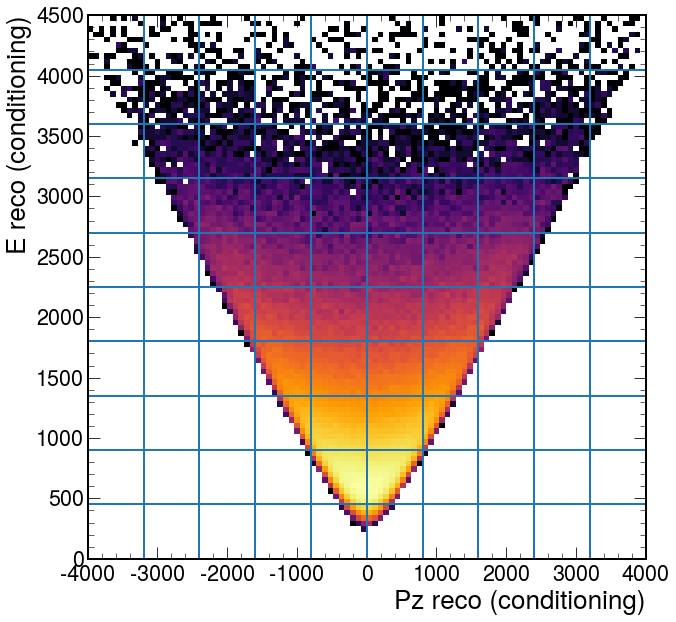

In [26]:
#Dividing reco space

pz_range = [-4000, 4000]
E_range = [0, 4500]
n_pz = 10
n_E = 10

seg_pz = np.linspace(pz_range[0], pz_range[1], n_pz+1)
seg_E = np.linspace(E_range[0], E_range[1], n_E+1)

plt.hist2d(y_cond[:,0],
           y_cond[:,1],
           bins=[100,100], range=[[-4000, 4000], [0,4500]], cmap="inferno", cmin=1, norm=LogNorm());
for i in seg_pz:
    plt.vlines(seg_pz, E_range[0], E_range[1])
    plt.hlines(seg_E, pz_range[0], pz_range[1])
plt.xlabel("Pz reco (conditioning)")
plt.ylabel("E reco (conditioning)")
plt.show()


In [27]:
def compare(y, x, pz_range, E_range):
    y_select, x_select = select_segments(y, x, pz_range, E_range)
    if y_select.shape[0] == 0:
        return None
    Y_select_scaled = torch.from_numpy(scaler.transform(y_select)).float()
    X_select_scaled = torch.from_numpy(scaler.transform(x_select)).float()
    out = flow(Y_select_scaled).sample((1, )).squeeze(0)
    
    print(len(X_select_scaled[:,0].numpy()), len(out[:,0].numpy()))
    
    plt.hist(X_select_scaled[:,0].numpy(), bins=30, histtype="step", label="target", range=(-5, 5))
    plt.hist(out[:,0].numpy(), bins=30, histtype="step", label="generated", range=(-5, 5))
    plt.legend()
    plt.title("pz")
    plt.show()
    
    plt.hist(X_select_scaled[:,1].numpy(), bins=30, histtype="step", label="target", range=(-5, 10))
    plt.hist(out[:,1].numpy(), bins=30, histtype="step", label="generated", range=(-5, 10))
    plt.legend()
    plt.title("E")
    plt.show()
    
    goodness_pz = scipy.stats.kstest(X_select_scaled[:,0].numpy(), out[:,0].numpy())
    print(goodness_pz)
    return 0
    

2407 2407


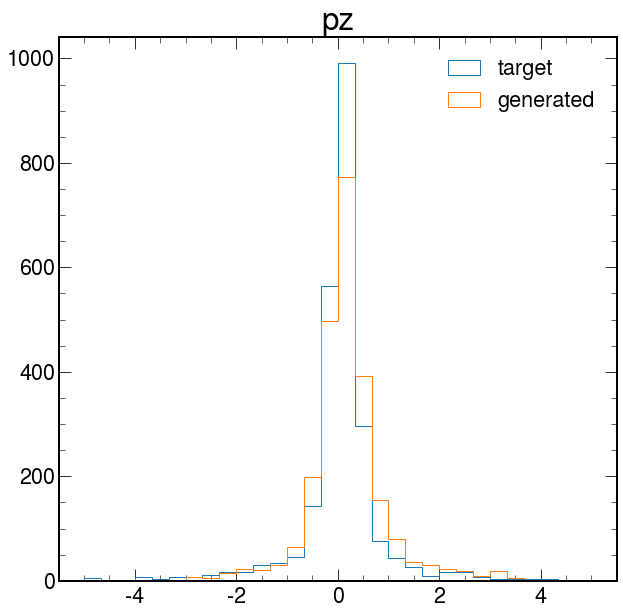

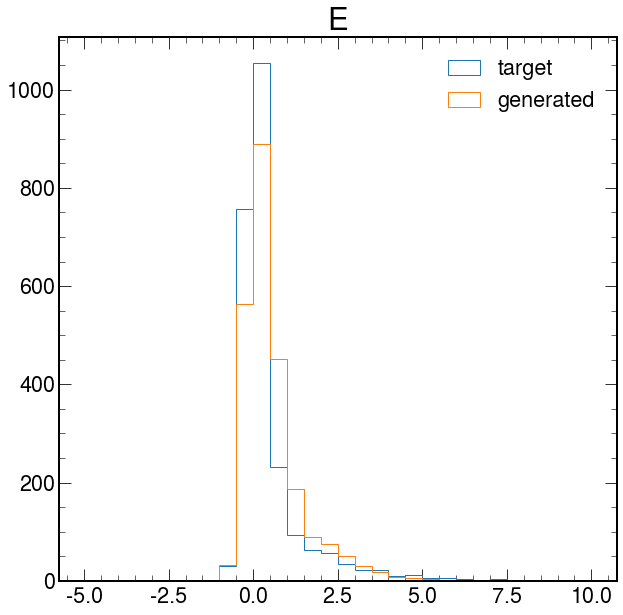

KstestResult(statistic=0.1154964686331533, pvalue=2.130307713731427e-14)


0

In [28]:
compare(y_cond, X, [0,100], [1000,1100])


In [34]:
def goodness(y, x, pz_range, E_range):
    y_select, x_select = select_segments(y, x, pz_range, E_range)
    if y_select.shape[0] < 10:
        return (None, None)
    Y_select_scaled = torch.from_numpy(scaler.transform(y_select)).float()
    X_select_scaled = torch.from_numpy(scaler.transform(x_select)).float()
    out = flow(Y_select_scaled).sample((1, )).squeeze(0)
    
    pz_goodness = scipy.stats.kstest(X_select_scaled[:,0].numpy(), out[:,0].numpy()).statistic
    E_goodness = scipy.stats.kstest(X_select_scaled[:,1].numpy(), out[:,1].numpy()).statistic
    
    return (pz_goodness, E_goodness)

In [ ]:
goodness(y_cond, X, [0,100], [1000,1100])

In [40]:
goodness_matrix_pz = np.zeros((n_pz, n_E))
goodness_matrix_E = np.zeros((n_pz, n_E))

for i in range(n_pz):
    print(i)
    for j in range(n_E):
        pz_goodness, E_goodness = goodness(y_cond, X, [seg_pz[i], seg_pz[i+1]], [seg_E[j], seg_E[j+1]])
        goodness_matrix_pz[n_E-j-1, i] = pz_goodness
        goodness_matrix_E[n_E-j-1, i] = E_goodness

0
1
2
3
4
5
6
7
8
9


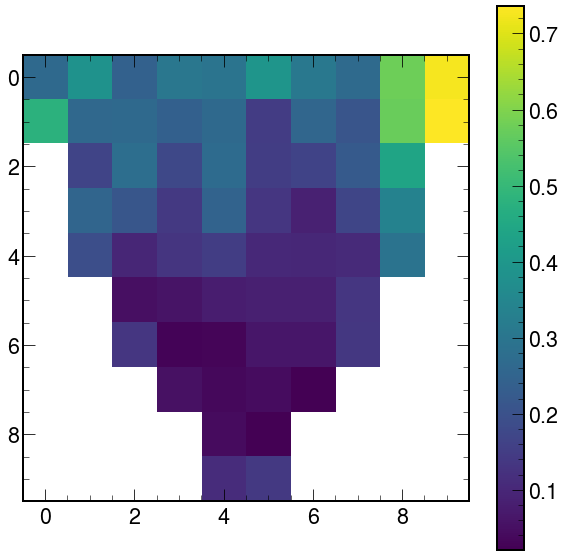

In [41]:
plt.imshow(goodness_matrix_pz, interpolation='none')
plt.colorbar()
plt.show()

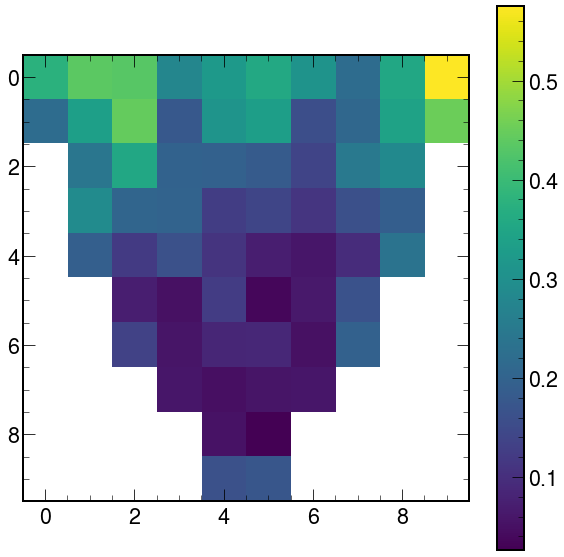

In [42]:
plt.imshow(goodness_matrix_E, interpolation='none')
plt.colorbar()
plt.show()

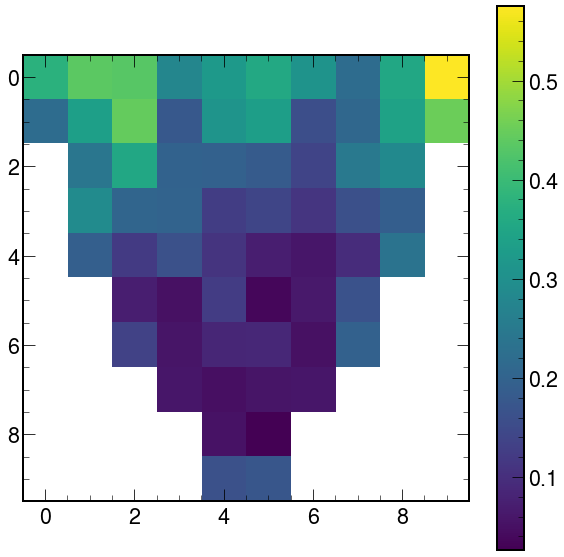

In [43]:
goodness_matrix_avg = (goodness_matrix_pz + goodness_matrix_E)*0.5

plt.imshow(goodness_matrix_E, interpolation='none')
plt.colorbar()
plt.show()


## 